In [1]:
# def mlpWrapper(df, test_parameters):

def mlpWrapper(df, test_parameters):

    # initialize
    start_time = time.time()
    random.seed()
    TTT_seed = randint(0,100)
    MLP_seed = randint(0,100)

    # smote training data
    oversample = SMOTE()
    X_smote, y_smote = oversample.fit_resample(df[df.columns[:-1]], df[df.columns[-1]])
    smote_df = X_smote.copy()
    smote_df['y'] = y_smote

    # split into train and test data
    train, test = train_test_split(
        smote_df,
        test_size = 0.2,
        random_state = TTT_seed
    )
    X_train = train[train.columns[:-1]]
    X_test = test[test.columns[:-1]]
    y_train = train[train.columns[-1]]
    y_test = test[test.columns[-1]]

    # call training function
    mlp = MLPClassifier(
        hidden_layer_sizes = test_parameters['hidden_layers'],
        activation = test_parameters['activation_function'],
        learning_rate_init = test_parameters['learning_rate'],
        batch_size = test_parameters['batch_size'],
        solver = test_parameters['solver'],
        random_state = MLP_seed,
        max_iter = 10000
    ).fit(X_train,y_train)

    # print out results
    result_train = mlp.score(X_train, y_train)
    result_test = mlp.score(X_test, y_test)

    stop_time = time.time()

    # return
    _return = {
        'TTT_seed': TTT_seed,
        'MLP_seed': MLP_seed,
        'smote_yes': y_smote.value_counts()[1],
        'smote_no': y_smote.value_counts()[0],
        'smote_yes_oversample': y_smote.value_counts()[1] - df[df.columns[-1]].value_counts()[1],
        'hidden_layers': test_parameters['hidden_layers'],
        'activation_function': test_parameters['activation_function'],
        'learning_rate': test_parameters['learning_rate'],
        'batch_size': test_parameters['batch_size'],
        'solver': test_parameters['solver'],
        'ellapsed_time': stop_time - start_time,
        'train': result_train,
        'test': result_test
    }

    return _return



In [2]:
# def mlpCrossValidate(df, test_parameters):

def mlpCrossValidate(df, test_parameters):

    # initialize
    random.seed()
    TTT_seed = randint(0,100)
    MLP_seed = randint(0,100)

    # smote training data
    oversample = SMOTE()
    X_smote, y_smote = oversample.fit_resample(df[df.columns[:-1]], df[df.columns[-1]])
    smote_df = X_smote.copy()
    smote_df['y'] = y_smote

    # call training function
    mlp = MLPClassifier(
        hidden_layer_sizes = test_parameters['hidden_layers'],
        activation = test_parameters['activation_function'],
        learning_rate_init = test_parameters['learning_rate'],
        batch_size = test_parameters['batch_size'],
        solver = test_parameters['solver'],
        random_state = MLP_seed,
        max_iter = 10000
    )

    scoring = ['precision_macro', 'recall_macro']
    scores = cross_validate(mlp, X_smote, y_smote, scoring=scoring, return_estimator=True)

    _feature_list = ''
    for _feature in df.columns:
        _feature_list += _feature + ', '

    # return
    _return = {
        'feature_list': _feature_list,
        'TTT_seed': TTT_seed,
        'MLP_seed': MLP_seed,
        'smote_yes': y_smote.value_counts()[1],
        'smote_no': y_smote.value_counts()[0],
        'smote_yes_oversample': y_smote.value_counts()[1] - df[df.columns[-1]].value_counts()[1],
        'hidden_layers': test_parameters['hidden_layers'],
        'activation_function': test_parameters['activation_function'],
        'learning_rate': test_parameters['learning_rate'],
        'batch_size': test_parameters['batch_size'],
        'solver': test_parameters['solver'],
        'fit_time': scores['fit_time'],
        'score_time': scores['score_time'],
        'test_precision_macro': scores['test_precision_macro'],
        'test_recall_macro': scores['test_recall_macro']
    }

    return pd.DataFrame(_return), scores['estimator']



In [3]:
# def categoricalEncoding(df, column):

def categoricalEncoding(df, column):
    df[column] = df[column].astype('category')
    df[column + '_cat'] = df[column].cat.codes
    df = df.drop(column, axis=1)
    return df

In [4]:
# def buildIterationList()

def buildIterationList(keys):

    build_list = []
    for i in range(0,len(keys)):
        new_key = keys[i]
        build_list.append(new_key)
        for j in range(0,len(keys)):
            if j > i:
                new_key += '+' + keys[j]
                build_list.append(new_key)

    return build_list

In [5]:
# def testLoop(ready, number_of_tests)

def testLoop(df, test_parameters, number_of_tests):

    # initialize return variable
    _all_runs = []

    # loop
    for _i in range(number_of_tests):
        
        # user feed back
        print('running test {}'.format(_i+1))
        
        # loop intializations
        _this_run = {}
        
        # conduct tests
        _results = mlpWrapper(df, test_parameters)

        # append results
        _all_runs.append(_results)

    # return results
    return pd.DataFrame(_all_runs)

In [6]:
# def runCombinationTests()

def runCombinationTests(df):

    
    # build work list
    features = [
        'age',
        'campaign',
        'pdays',
        'previous',
        'emp.var.rate',
        'cons.price.idx',
        'cons.conf.idx',
        'euribor3m',
        'nr.employed',
        'job_cat',
        'marital_cat'
    ]
    features.remove('y_cat')
    build_list = buildIterationList(features)

    # initialize dictionary
    _selections = []
    _TTT_seeds = []
    _MLP_seeds = []
    _tests = []
    _trainings = []

    # run tests
    for i,key in enumerate(build_list):

        # build data frames
        requests = key.split('+')
        for request in requests:
            builder = df[requests]
        builder['y_cat'] = df['y_cat'].values

        # run test
        print('MLP using columns {}'.format(key.replace('+',', ')))
        this_test = testLoop(builder, 1)

        # print results
        print('Training accuracy: {:.4%}'.format(this_test.train.mean()))
        print('Testing accuracy: {:.4%}'.format(this_test.test.mean()))
        print()

        # build output dataframe
        _selections.append(key)  
        # print(this_test)
        _TTT_seeds.append(this_test.iloc[0, 0])
        _MLP_seeds.append(this_test.iloc[0,1]) 
        _tests.append(this_test.iloc[0,2]) 
        _trainings.append(this_test.iloc[0,3])

    # create output dataframe
    _rows = {}
    _rows['selections'] = _selections
    _rows['TTT_seed'] = _TTT_seeds
    _rows['MLP_seeds'] = _MLP_seeds
    _rows['tests'] = _tests
    _rows['train'] = _trainings
    results_df = pd.DataFrame.from_dict(_rows)

    # write results dataframe to file
    f = open('results.csv','w')
    results_df.to_csv(f)
    f.close()

In [7]:
# def correlationHeatmap(correlation_matrix)
def correlationHeatmap(correlation_matrix):
    plt.figure(figsize=(20,10))
    plt.title(
        'Triangle Correlation Heatmap',
        fontdict={'fontsize': 20},
        pad = 20
    )
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    import seaborn
    seaborn.heatmap(
        correlation_matrix,
        mask=mask,
        vmin=-1,
        vmax=1,
        annot=True,
        cmap='BrBG'
    )

In [8]:
# def loadData():

def loadData(mute):
    _file_name = '../bank-additional/bank-additional/bank-additional-full.csv'
    _df = pd.read_csv(_file_name, sep=';')
    if not mute: print('Rows before drop duplicates: {}'.format(_df.shape[0]))
    _df = _df.drop_duplicates(keep='first')
    if not mute: print('Rows after drop duplicates: {}'.format(_df.shape[0]))
    if not mute: print('There are {} features.'.format(_df.shape[1]))
    if not mute: print(_df.dtypes)
    return _df

In [9]:
# def normalizeZScore(df)

def normalizeZScore(data_frame, excluded_columns):
    _return = data_frame.copy()
    for _column in _return.columns:
        if _column not in excluded_columns:
            _return[_column] = (_return[_column] - _return[_column].mean()) / _return[_column].std()
    return _return

In [10]:
# def plotEigan(df):
 
def plotEigan(df):
    _eigan_df = df.copy()
    _eigan_df = _eigan_df.drop(['y_cat'], axis=1)
    _feature_count = _eigan_df.shape[1]
    _covariance_matrix = np.cov(_eigan_df.T)
    _w, _v = np.linalg.eig(_covariance_matrix)
    plt.figure(figsize=(15,8))
    plt.plot(np.arange(1,_feature_count+1), _w, marker='o')
    for i,j in zip(np.arange(1,_feature_count+1), _w):
        plt.annotate('{:.2f}'.format(j), xy=(i,j), rotation=15)
    plt.xticks(np.arange(1, _feature_count+1), _eigan_df.columns, rotation=60)  # Set label locations.
    plt.xlabel("Feature")
    plt.ylabel("Eigan Value")
    plt.title("Eigan Values of Features") 

In [11]:
# IMPORTS
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from random import randint 
import random
import pprint
from imblearn.over_sampling import SMOTE
import time
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [12]:
# LOAD DATA

df = loadData(False)

Rows before drop duplicates: 41188
Rows after drop duplicates: 41176
There are 21 features.
age                 int64
job                object
marital            object
education          object
default            object
housing            object
loan               object
contact            object
month              object
day_of_week        object
duration            int64
campaign            int64
pdays               int64
previous            int64
poutcome           object
emp.var.rate      float64
cons.price.idx    float64
cons.conf.idx     float64
euribor3m         float64
nr.employed       float64
y                  object
dtype: object


In [13]:
# ENCODE COLUMNS
_categorical_columns = [
    'job',
    'marital',
    'education',
    'default',
    'housing',
    'loan',
    'contact',
    'month',
    'day_of_week',
    'poutcome',
    'y'
]
for _column in _categorical_columns:
    df = categoricalEncoding(df, _column)
print(df.columns)


Index(['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate',
       'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed',
       'job_cat', 'marital_cat', 'education_cat', 'default_cat', 'housing_cat',
       'loan_cat', 'contact_cat', 'month_cat', 'day_of_week_cat',
       'poutcome_cat', 'y_cat'],
      dtype='object')


([<matplotlib.axis.XTick at 0x7fca9c6035b0>,
 [Text(0.2, 0, 'no'), Text(0.8, 0, 'yes')])

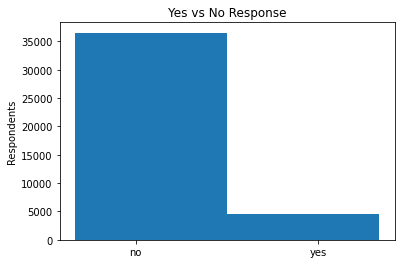

In [20]:
# YES OR NO

df['y_cat'].hist(bins=2, grid=False)
plt.title('Yes vs No Response')
plt.ylabel('Respondents')
plt.xticks([0.2,0.8],['no', 'yes'])

In [19]:
# NUMERIC DATAFRAME
_numeric_columns = [
    'age',
    'duration',
    'campaign',
    'pdays',
    'previous',
    'emp.var.rate',
    'cons.price.idx',
    'cons.conf.idx',
    'euribor3m',
    'nr.employed'
]
for _column in _categorical_columns:
    _numeric_columns.append(_column + '_cat')
numeric_df = df[_numeric_columns]

In [20]:
# NORMALIZED DATAFRAME

normalized_df = normalizeZScore(df, ['y_cat'])

In [21]:
print(normalized_df['y_cat'].value_counts())

0    36537
1     4639
Name: y_cat, dtype: int64


In [22]:
# DROP DURATION PER REQUIREMENT
normalized_df = normalized_df.drop(['duration'], axis=1)

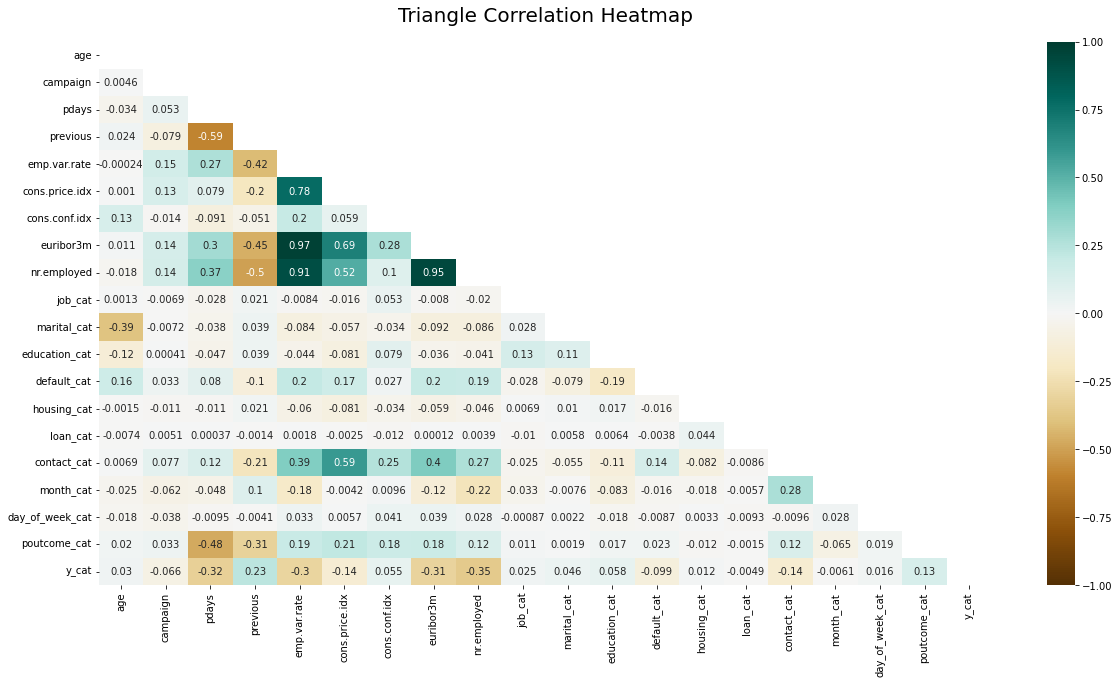

In [752]:
# CORRELATION HEATMAP OF NUMERIC DATAFRAMES
correlationHeatmap(normalized_df.corr())

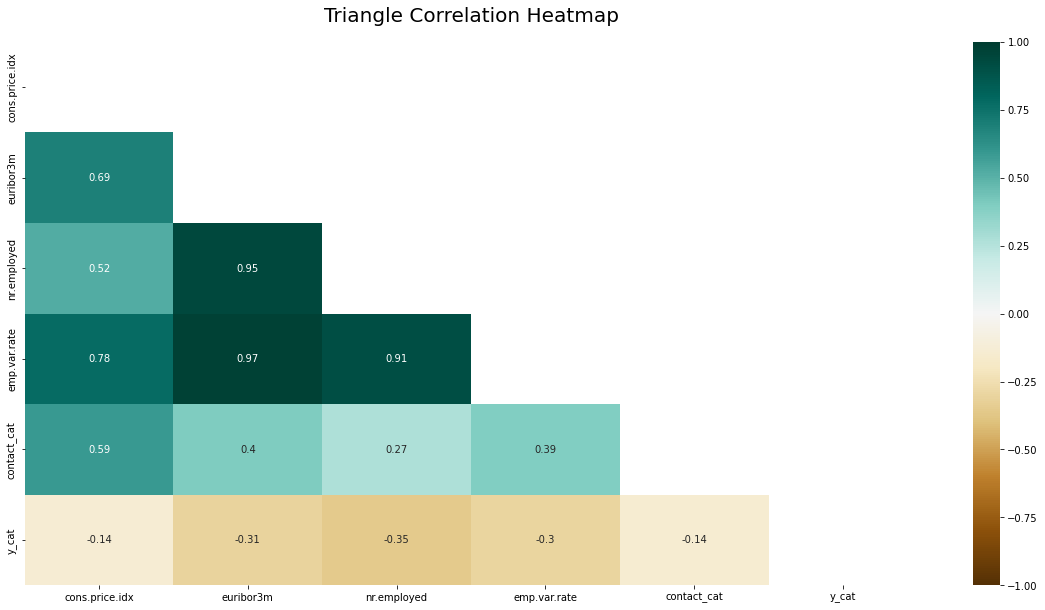

In [753]:
# INVESTIGATING CONS.PRICE.IDX, EURIBOR3M, NR.EMPLOYED, EMP.VAR.RATE, CONTACT
_investigation_columns = [
    'cons.price.idx',
    'euribor3m',
    'nr.employed',
    'emp.var.rate',
    'contact_cat',
    'y_cat'
]
_investigation_df = df[_investigation_columns]
correlationHeatmap(_investigation_df.corr())

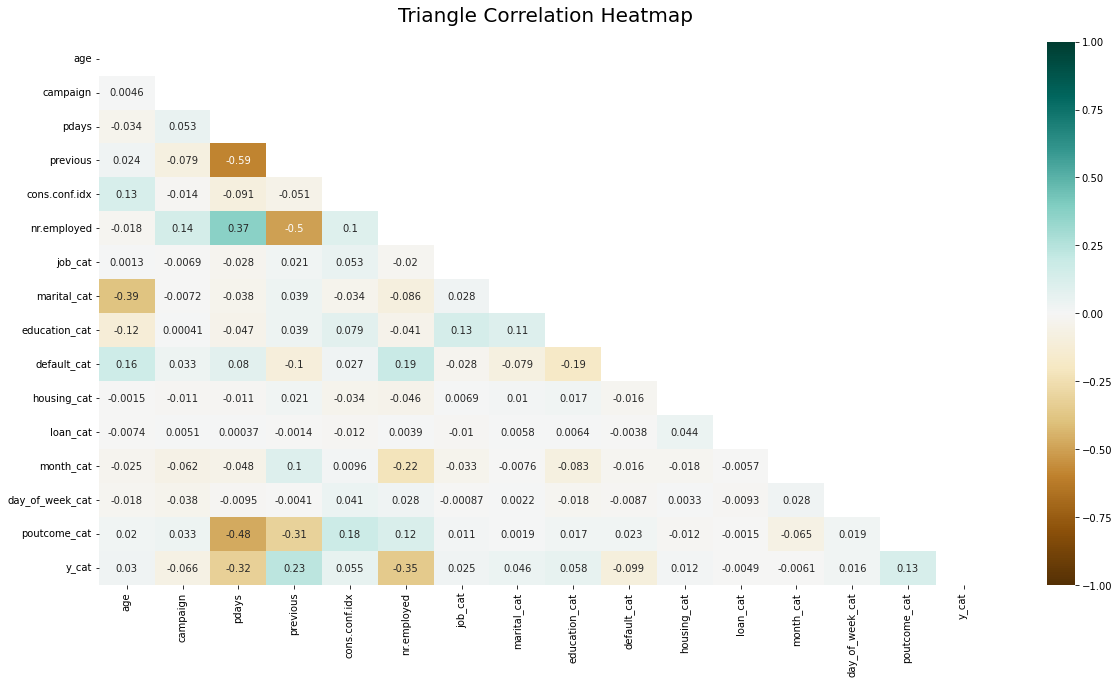

In [754]:
# CORRELATION BASED FEATURE REDUCTION
_remove_columns = _investigation_columns
try:
    _remove_columns.remove('nr.employed')
    _remove_columns.remove('y_cat')
    _remove_columns.append('duration')
except:
    pass
try:
    _reduced_columns = _numeric_columns
    for _column in _remove_columns:
        _reduced_columns.remove(_column)
except:
    pass
_reduced_df = df[_reduced_columns]
correlationHeatmap(_reduced_df.corr())

Text(0.5, 1.0, 'Scree')

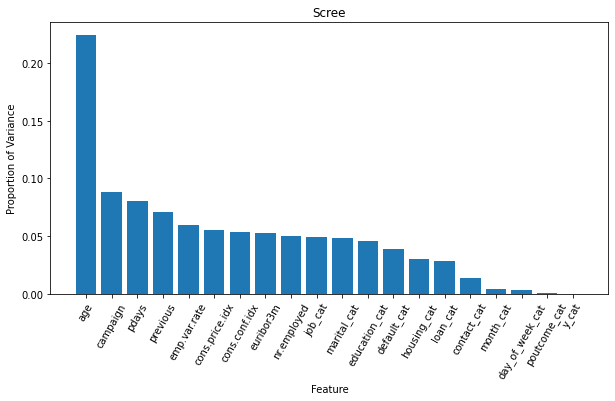

In [755]:
# VARIANCE
from sklearn.decomposition import PCA

pca = PCA().fit(normalized_df)
_feature_count = normalized_df.shape[1]
plt.figure(figsize=(10,5))
plt.bar(np.arange(1, _feature_count+1), pca.explained_variance_ratio_)
plt.xticks(np.arange(1, _feature_count+1), normalized_df.columns, rotation=60)  # Set label locations.
plt.xlabel("Feature")
plt.ylabel("Proportion of Variance")
plt.title("Scree")

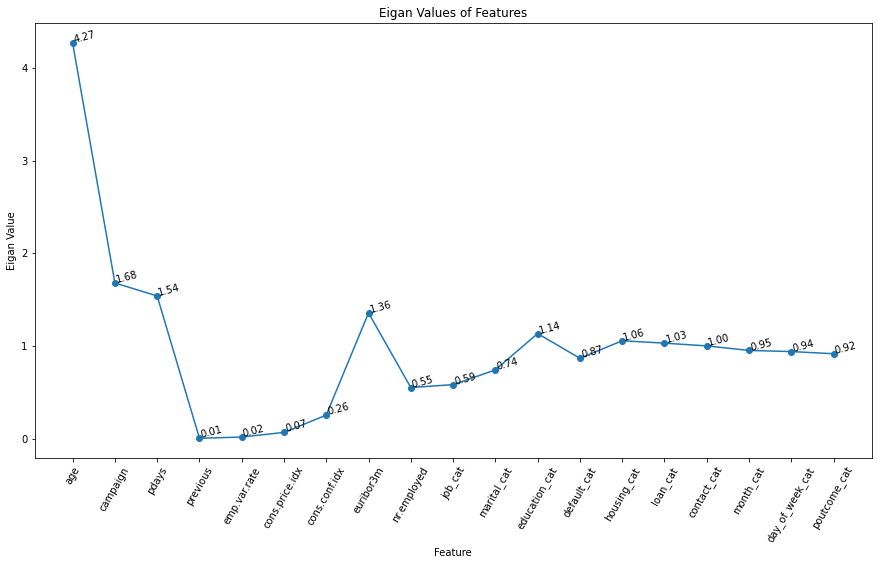

In [756]:
# EIGAN VALUE PLOT

plotEigan(normalized_df)

In [757]:

feature_list = [
    'age',
    'campaign',
    'pdays',
    'previous',
    'emp.var.rate',
    'cons.price.idx',
    'cons.conf.idx',
    'euribor3m',
    'nr.employed',
    'job_cat',
    'marital_cat',
    'education_cat',
    'default_cat',
    'housing_cat',
    'loan_cat',
    'contact_cat',
    'month_cat',
    'day_of_week_cat',
    'poutcome_cat'
]

Testing hidden layers at 2
running test 1
running test 2
running test 3
running test 4
running test 5
Testing hidden layers at 4
running test 1
running test 2
running test 3
running test 4
running test 5
Testing hidden layers at 8
running test 1
running test 2
running test 3
running test 4
running test 5
Testing hidden layers at 16
running test 1
running test 2
running test 3
running test 4
running test 5
Testing hidden layers at 32
running test 1
running test 2
running test 3
running test 4
running test 5
Testing hidden layers at 64
running test 1
running test 2
running test 3
running test 4
running test 5
Testing hidden layers at 128
running test 1
running test 2
running test 3
running test 4
running test 5


[0.7172630858706807, 0.7197536777283613, 0.7238043106397536, 0.7228053369825521, 0.719521040027369, 0.7212589804994868, 0.724406431748204]
[0.007320989505093176, 0.00643054705229542, 0.0036994560617270578, 0.0038637410422012897, 0.007148370961423415, 0.005105280305814118, 0.00538357861914412]
[32.016858386993405, 33.379113817214964, 34.441713857650754, 36.62815232276917, 33.809882736206056, 42.79039092063904, 46.96352620124817]
[15.875624632058729, 8.815888673968283, 4.8731999427291495, 7.120612936511819, 8.064129758328711, 14.239158387699101, 6.490643532499596]


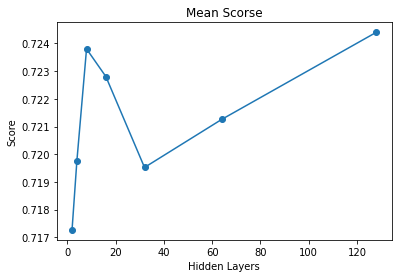

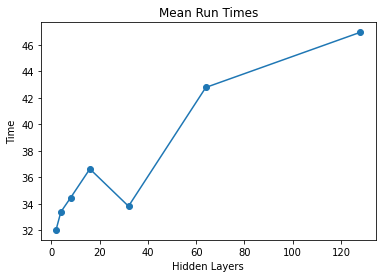

In [915]:
plt.plot(_hidden_layers, _ellapsed_time_means, marker='o')
plt.title('Mean Run Times')
plt.ylabel('Time')
plt.xlabel('Hidden Layers')
plt.show()

Testing hidden layers at 0.1
running test 1
running test 2
running test 3
running test 4
running test 5
Testing hidden layers at 0.01
running test 1
running test 2
running test 3
running test 4
running test 5
Testing hidden layers at 0.001
running test 1
running test 2
running test 3
running test 4
running test 5


In [931]:
_test_means = []
_test_stds = []
_ellapsed_time_means = []
_ellapsed_time_stds = []
for _value in _learning_rates:
    _eval_df = all_results_df[all_results_df['learning_rate'] == _value]
    _test_means.append(_eval_df['test'].mean())
    _test_stds.append(_eval_df['test'].std())
    _ellapsed_time_means.append(_eval_df['ellapsed_time'].mean())
    _ellapsed_time_stds.append(_eval_df['ellapsed_time'].std())

In [3]:
plt.plot(_learning_rates, _test_means, marker='o')
plt.title('Mean Scorse')
plt.ylabel('Score')
plt.xlabel('Learning Rates')
plt.show()

NameError: name '_learning_rates' is not defined

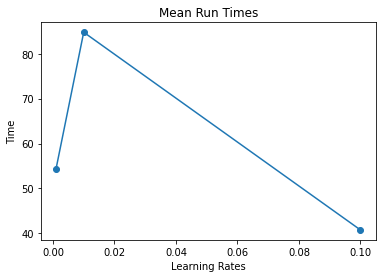

In [934]:
plt.plot(_learning_rates, _ellapsed_time_means, marker='o')
plt.title('Mean Run Times')
plt.ylabel('Time')
plt.xlabel('Learning Rates')
plt.show()

In [23]:
# TEST BATCH SIZE

_features = ['age', 'pdays', 'nr.employed', 'y_cat']
_mlp_df = normalized_df[_features]
_batch_sizes = [10, 100]
all_results_df = pd.DataFrame()
for _value in _batch_sizes:
    print('Testing hidden layers at {}'.format(_value))
    _test_parameters = {
        'hidden_layers': 64,
        'activation_function': 'logistic',
        'learning_rate': 0.1,
        'batch_size': _value,
        'solver': 'sgd'
    }
    _results = testLoop(_mlp_df, _test_parameters, 5)
    all_results_df = pd.concat([all_results_df, _results], axis=0)
all_results_df.to_csv('batch_size_test_results.csv')

Testing hidden layers at 10
running test 1
running test 2
running test 3
running test 4
running test 5
Testing hidden layers at 100
running test 1
running test 2
running test 3
running test 4
running test 5


In [24]:
_test_means = []
_test_stds = []
_ellapsed_time_means = []
_ellapsed_time_stds = []
for _value in _batch_sizes:
    _eval_df = all_results_df[all_results_df['batch_size'] == _value]
    _test_means.append(_eval_df['test'].mean())
    _test_stds.append(_eval_df['test'].std())
    _ellapsed_time_means.append(_eval_df['ellapsed_time'].mean())
    _ellapsed_time_stds.append(_eval_df['ellapsed_time'].std())

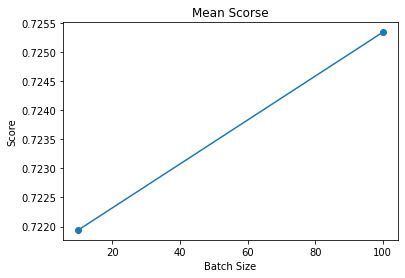

In [25]:
plt.plot(_batch_sizes, _test_means, marker='o')
plt.title('Mean Scorse')
plt.ylabel('Score')
plt.xlabel('Batch Size')
plt.show()

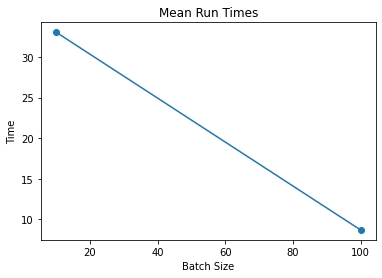

In [27]:
plt.plot(_batch_sizes, _ellapsed_time_means, marker='o')
plt.title('Mean Run Times')
plt.ylabel('Time')
plt.xlabel('Batch Size')
plt.show()

In [935]:
# MLP
_features = ['age', 'campaign', 'pdays', 'nr.employed', 'marital_cat', 'default_cat', 'education_cat', 'month_cat', 'day_of_week_cat', 'y_cat']
_mlp_df = normalized_df[_features]
_test_parameters = {
    'hidden_layers': 32,
    'activation_function': 'logistic',
    'learning_rate': 0.1,
    'batch_size': 10,
    'solver': 'sgd'
}
# _results = testLoop(_mlp_df, _test_parameters, 2)
results, estimators = mlpCrossValidate(_mlp_df, _test_parameters)

_ts = time.time()
results.to_csv('results {}.csv'.format(_ts))

/Users/johnmachado/Documents/CSI5810/P01/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:699: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


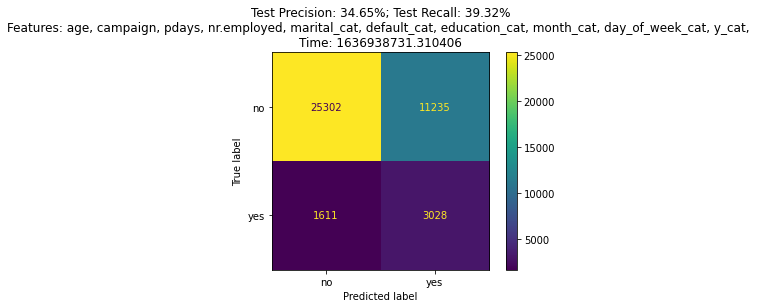

In [ ]:
_predicted = estimators[0].predict(_mlp_df[_mlp_df.columns[:-1]])
_cm = confusion_matrix(_mlp_df[_mlp_df.columns[-1]], _predicted)
_labels = ['no', 'yes']
disp = ConfusionMatrixDisplay(
    confusion_matrix = _cm, 
    display_labels = _labels
)
disp.plot()
plt.title('Test Precision: {:.2%}; Test Recall: {:.2%}\nFeatures: {}\nTime: {}'.format(results.iloc[0,13], results.iloc[0,14], results.iloc[0,0], _ts))
plt.show()

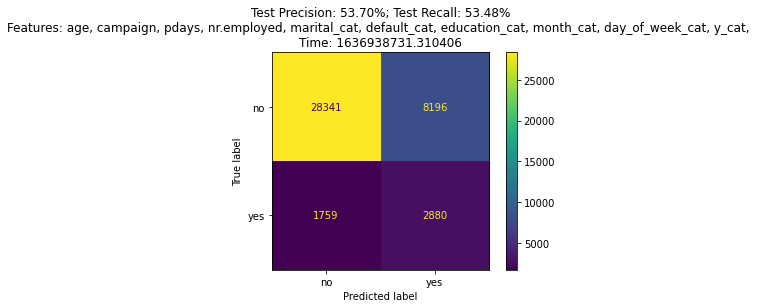

In [ ]:
_predicted = estimators[0].predict(_mlp_df[_mlp_df.columns[:-1]])
_cm = confusion_matrix(_mlp_df[_mlp_df.columns[-1]], _predicted)
_labels = ['no', 'yes']
disp = ConfusionMatrixDisplay(
    confusion_matrix = _cm, 
    display_labels = _labels
)
disp.plot()
plt.show()

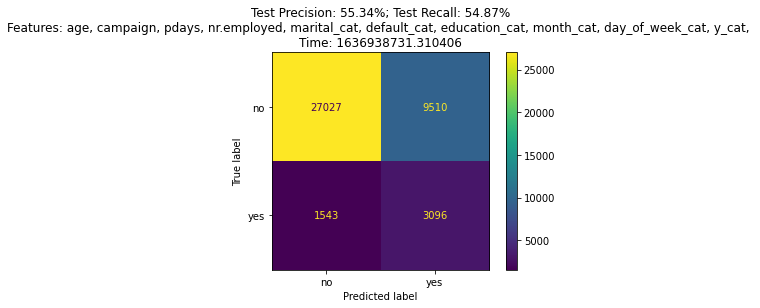

In [ ]:
_predicted = estimators[2].predict(_mlp_df[_mlp_df.columns[:-1]])
_cm = confusion_matrix(_mlp_df[_mlp_df.columns[-1]], _predicted)
_labels = ['no', 'yes']
disp = ConfusionMatrixDisplay(
    confusion_matrix = _cm, 
    display_labels = _labels
)
disp.plot()
plt.title('Test Precision: {:.2%}; Test Recall: {:.2%}\nFeatures: {}\nTime: {}'.format(results.iloc[2,13], results.iloc[2,14], results.iloc[2,0], _ts))
plt.show()

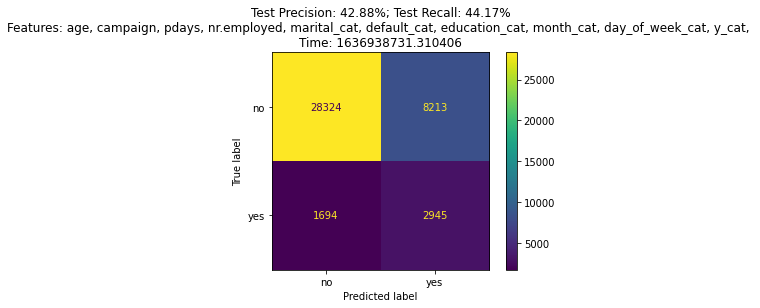

In [ ]:
_predicted = estimators[3].predict(_mlp_df[_mlp_df.columns[:-1]])
_cm = confusion_matrix(_mlp_df[_mlp_df.columns[-1]], _predicted)
_labels = ['no', 'yes']
disp = ConfusionMatrixDisplay(
    confusion_matrix = _cm, 
    display_labels = _labels
)
disp.plot()
plt.title('Test Precision: {:.2%}; Test Recall: {:.2%}\nFeatures: {}\nTime: {}'.format(results.iloc[3,13], results.iloc[3,14], results.iloc[3,0], _ts))
plt.show()

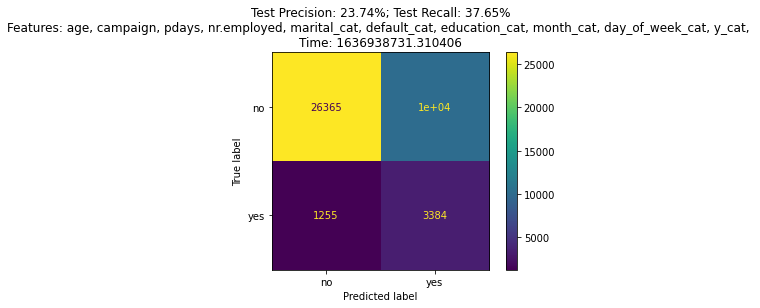

In [ ]:
_predicted = estimators[4].predict(_mlp_df[_mlp_df.columns[:-1]])
_cm = confusion_matrix(_mlp_df[_mlp_df.columns[-1]], _predicted)
_labels = ['no', 'yes']
disp = ConfusionMatrixDisplay(
    confusion_matrix = _cm, 
    display_labels = _labels
)
disp.plot()
plt.title('Test Precision: {:.2%}; Test Recall: {:.2%}\nFeatures: {}\nTime: {}'.format(results.iloc[4,13], results.iloc[4,14], results.iloc[4,0], _ts))
plt.show()

In [ ]:
_scores = []
for _ in range(100):
     # split into train and test data
     random.seed()
     _train, _test = train_test_split(
          _mlp_df,
          test_size = 0.7,
          random_state = randint(1,100)
     )
     _X_train = _train[_train.columns[:-1]]
     _X_test = _test[_test.columns[:-1]]
     _y_train = _train[_train.columns[-1]]
     _y_test = _test[_test.columns[-1]]
     _scores.append(estimators[2].score(_X_test, _y_test))
_score_df = pd.DataFrame(_scores)
print('Mean of 100 scores for model #2: {:.2%}'.format(_score_df.iloc[:,0].mean()))
print('Standard deviation: {:.2%}'.format(_score_df.iloc[:,0].std()))

Mean of 100 scores for model #2: 73.14%
Standard deviation: 0.13%
